# MMF PIMs from a .MAT file

In [36]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import torch
from torch.nn import Parameter
import torchoptics
from torchoptics import Field, System, Param

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

# Set simulation properties
shape = 1000  # Number of grid points in each dimension
spacing = 10e-6  # Spacing between grid points (m)
wavelength = 700e-9  # Field wavelength (m)
focal_length = 200e-3  # Lens focal length (m)
tile_length = 400e-6  # Checkerboard tile length (m)
num_tiles = 15  # Number of tiles in each dimension

# Configure torchoptics default properties
torchoptics.set_default_spacing(spacing)
torchoptics.set_default_wavelength(wavelength)

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [3]:
data = sc.io.loadmat("c:/Users/elija/Documents/MATLAB/MPhys Project/Modes.mat")
# data = sc.io.loadmat("Modes.mat")
x = data["F2"]
print(x.shape)
#print(type(x))

(31, 31, 42)


In [4]:
#x.reshape(42,31,31)[0]

In [5]:
#test = np.array([[[1,1,1],[2,2,2],[3,3,3]],[[4,4,4],[5,5,5],[6,6,6]]])
#print(test.shape)
#print(test)

In [6]:
#x.transpose(2,0,1)[0]

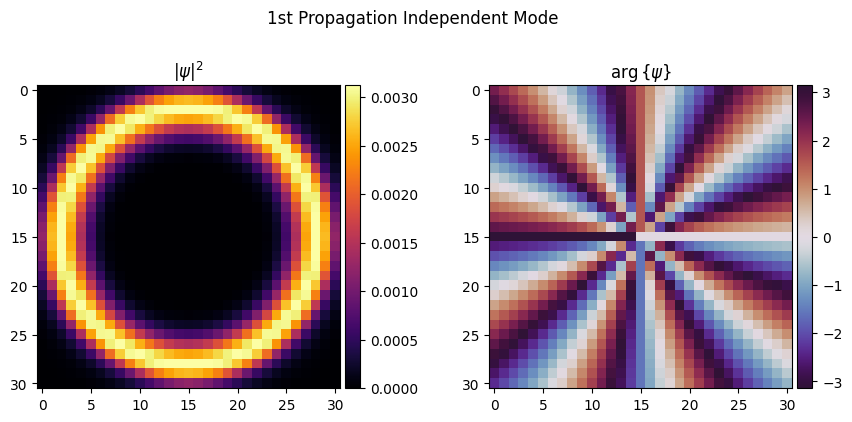

In [ ]:
field_data = torch.from_numpy(x.transpose(2,0,1)[0])
input_field = Field(field_data).to(device)

input_field.visualize(title="1st Propagation Independent Mode")

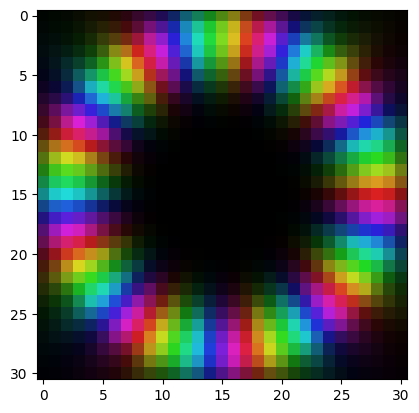

In [8]:
from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

plt.imshow(Complex2HSV(x.transpose(2,0,1)[0], 0, 0.065))
plt.show()

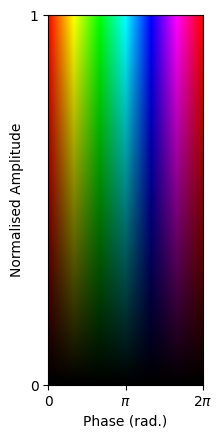

In [9]:
V, H = np.mgrid[0:1:100j, 0:1:300j]
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
RGB = hsv_to_rgb(HSV)

plt.imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

plt.xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
plt.yticks([0, 1], ['0', '1'])

plt.ylabel("Normalised Amplitude")
plt.xlabel("Phase (rad.)")

plt.show()

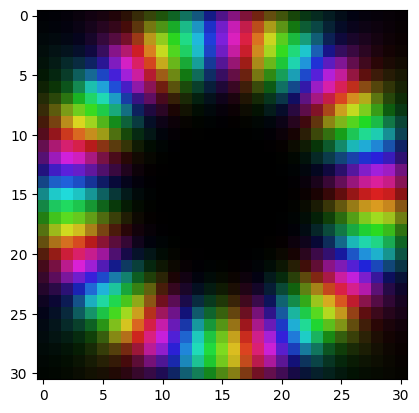

In [10]:
fig = plt.figure()
ax = fig.add_subplot()

for i in np.arange(0,42,1):
    plt.imshow(Complex2HSV(x.transpose(2,0,1)[i], 0, 0.065))

    fig.savefig(f"Modes Folder/MMF Mode {i+1}.png", dpi = 100)


## Propagate these modes through a perfect MMF

1) Modes originally in pixel basis, need converting to a fibre mode basis.
2) Multiplied by a PIM to PIM transmission matrix (TM) using phase velocities for each mode (given as beta in the MATLAB code)
3) Re-express the transmitted field in the pixel basis

The result should be the same spatial structure of the mode (as they're propagation invariant) but with an altered phase. The whole transformation can be represented using a Real space to Real space TM.

4) Using all the nodes (42 of them) try to separately find the length of an MMF using their phase changes

Exerpt from: Memory effect assisted imaging through
multimode optical fibres (Methods Section)

"Once the 2D complex functions describing each PIM have been
found, column n of matrix P is constructed by representing the complex field of the
nth PIM in Cartesian coordinates on a 2D grid, and reshaping it into a column
vector "


In [11]:
# Convert modes into a fibre basis
modes = x.transpose(2,0,1)
# Reshape modes into a column vector and stitch them together to form the matrix
modes[0].reshape(961,1)
modes[1].reshape(961,1)

a = 961 # No. pixels in real space field
b = 42 # No. PIMs

pim = modes[0].reshape(961,1)

for i in np.arange(0,b-1,1):
    pim = np.concatenate([pim, modes[i+1].reshape(a,1)],axis=1)
    #print(pim.shape)

#pim
pim.shape

(961, 42)

In [12]:
# Take the conjugate transpose of the pim matrix to be used in returning the field back to pixel coords
pim_dag = np.transpose(np.conj(pim))
pim_dag.shape

# pim_dag matrix multiplied by pim should result in something close to the identity matrix
#pim_dag@pim
# Hard to tell if it is correct (based on first couple of rows it seems okay)

(42, 961)

In [13]:
# Import the phase velocities (beta) for each mode
data = sc.io.loadmat("c:/Users/elija/Documents/MATLAB/MPhys Project/Beta.mat")
beta = data["Beta"]
#beta

In [14]:
# Make a diagonal PIM to PIM TM (each term is exp(i*L*beta), where L is the length of the MMF)
beta_arr = np.zeros((42,42)).astype(complex)
L=1
im = np.sqrt(-1+0j)

for i in np.arange(0,beta_arr.shape[0],1):
    for j in np.arange(0,beta_arr.shape[0],1):
        if i==j:
            beta_arr[i,j] = np.exp(im*L*beta[i])
        else:
            pass

#beta_arr

C:\Users\elija\AppData\Local\Temp\ipykernel_11372\3232166047.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_arr[i,j] = np.exp(im*L*beta[i])


In [15]:
# Form the Real space to Real space transmission matrix

TM = pim @ beta_arr @ pim_dag

In [16]:
# Make a function for the TM
def TM(beta, mode_fields, no_pims, pixel, L):
    """Forms a transmission matrix, TM, based on externally generated modes and their corresponding phase velocities.
    beta = phase velocities for modes (given as an ordered list array)
    mode_field = 2D electric field of the propagation invariant modes (PIMs), given as a 3D array
    no_pims = number of PIMs that can travel through the multimode optical fibre (MMF)
    pixel = total number of pixels the 2D electric field covers in real space
    L = Length of the MMF"""

    beta_arr = np.zeros((no_pims,no_pims)).astype(complex)
    im = np.sqrt(-1+0j)

    # Create the real space to PIM matrix
    pim = mode_fields[0].reshape(pixel,1)

    for i in np.arange(0,no_pims-1,1):
        pim = np.concatenate([pim, mode_fields[i+1].reshape(pixel,1)],axis=1)
    
    # Take the conjugate transpose of the pim matrix to be used in returning the field back to pixel coords
    pim_dag = np.transpose(np.conj(pim))

    # Make a diagonal PIM to PIM TM (each term is exp(i*L*beta), where L is the length of the MMF)
    for i in np.arange(0,no_pims,1):
        for j in np.arange(0,no_pims,1):
            if i==j:
                beta_arr[i,j] = np.exp(im*L*beta[i])
            else:
                pass
    
    # Combine each matrix to make the full TM for the MMF
    return pim @ beta_arr @ pim_dag


# Make a vectorising function
def vectorise(field):
    """Converts a 2D field and vectorises it into a column matrix.
    field = matrix representation of field"""
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def rev_vector(field, dim):
    """Converts a vectorised field back into a 2D square matrix representation.
    field = vectorised field
    dim = number of pixels on one side of the square matrix it will be turned into"""
    return field.reshape(dim,dim)


In [17]:
test = np.zeros((3,3)).astype(complex)
print(f"Original:\n {test}")

for i in np.arange(0,test.shape[0],1):
    for j in np.arange(0,test.shape[0],1):
        if i==j:
            test[i,j] = np.exp(im*L)
        else:
            pass

print(f"\nFinal:\n {test}")

Original:
 [[0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]]

Final:
 [[0.54030231+0.84147098j 0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.54030231+0.84147098j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.54030231+0.84147098j]]


### Testing transmission matrix
Using mode n=20 (19 in code)

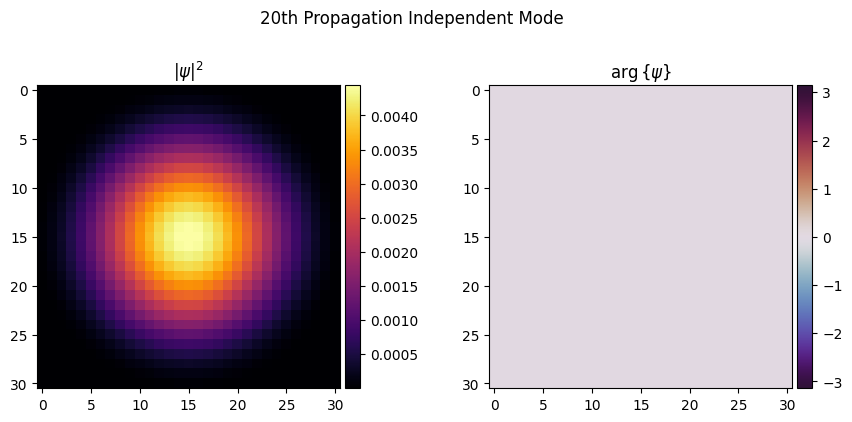

In [18]:
field_data = torch.from_numpy(modes[19])
input_field = Field(field_data).to(device)

input_field.visualize(title="20th Propagation Independent Mode")

C:\Users\elija\AppData\Local\Temp\ipykernel_11372\841074018.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_arr[i,j] = np.exp(im*L*beta[i])


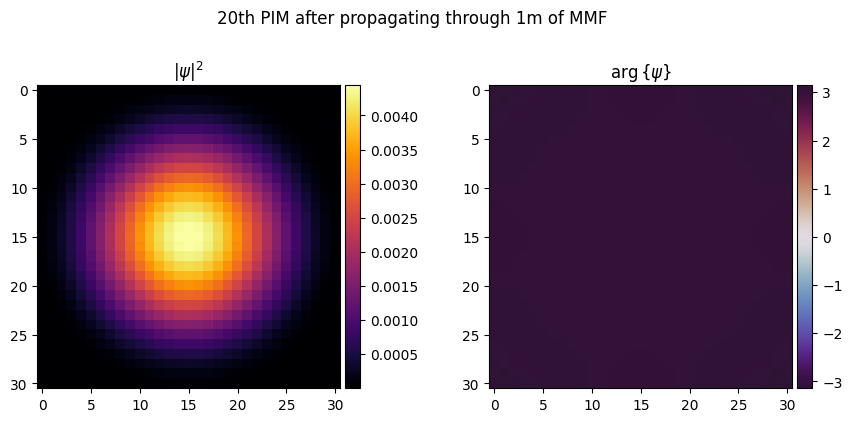

In [19]:
output_field_vec = TM(beta=beta, mode_fields=modes, no_pims=42, pixel=961, L=1) @ vectorise(modes[19])
output_field =  rev_vector(output_field_vec,31)

new_field = Field(torch.from_numpy(output_field)).to(device)
new_field.visualize(title="20th PIM after propagating through 1m of MMF")

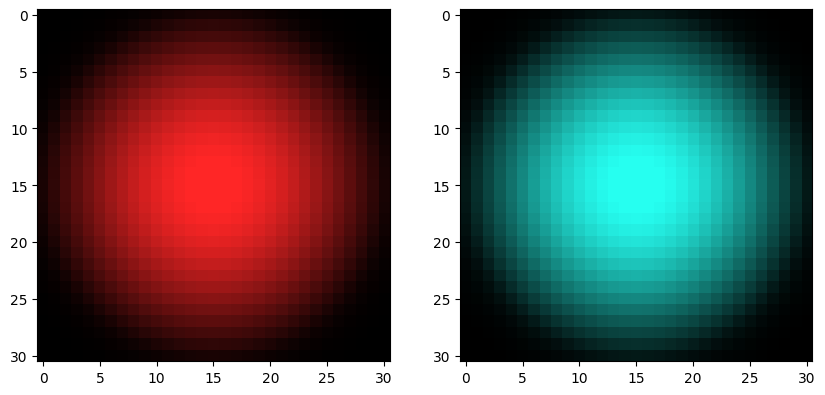

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(Complex2HSV(modes[19], 0, 0.065))
axs[1].imshow(Complex2HSV(output_field, 0, 0.065))

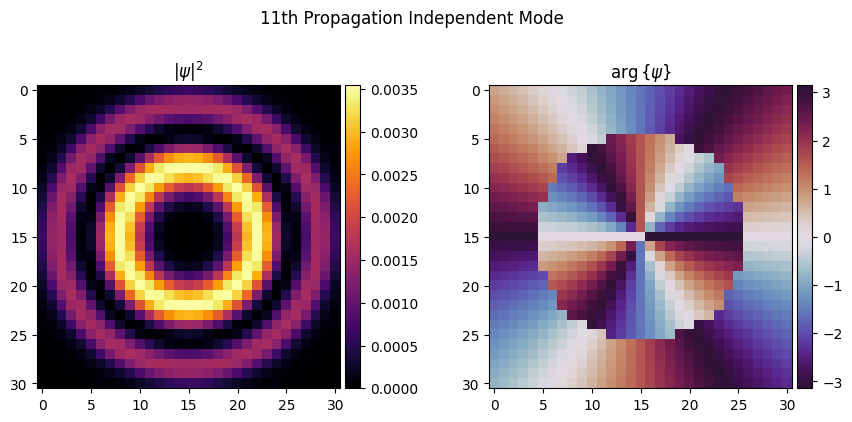

In [21]:
field_data = torch.from_numpy(modes[10])
input_field = Field(field_data).to(device)

input_field.visualize(title="11th Propagation Independent Mode")

C:\Users\elija\AppData\Local\Temp\ipykernel_11372\841074018.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_arr[i,j] = np.exp(im*L*beta[i])


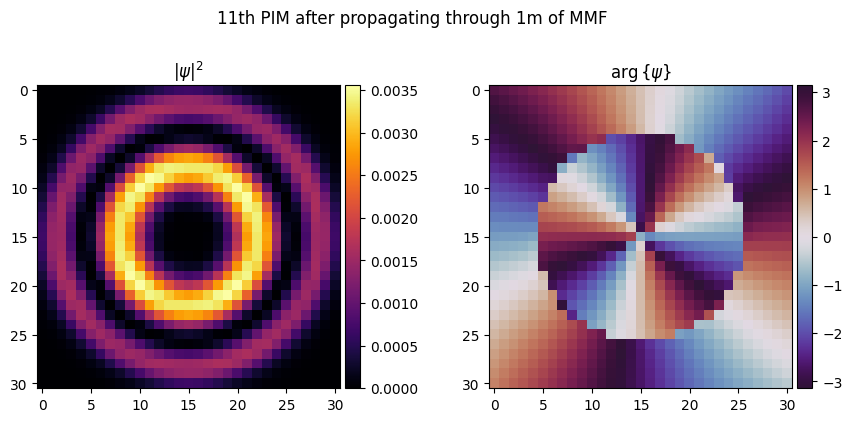

In [22]:
output_field_vec = TM(beta=beta, mode_fields=modes, no_pims=42, pixel=961, L=1) @ vectorise(modes[10])
output_field = rev_vector(output_field_vec,31)

new_field = Field(torch.from_numpy(output_field)).to(device)
new_field.visualize(title="11th PIM after propagating through 1m of MMF")

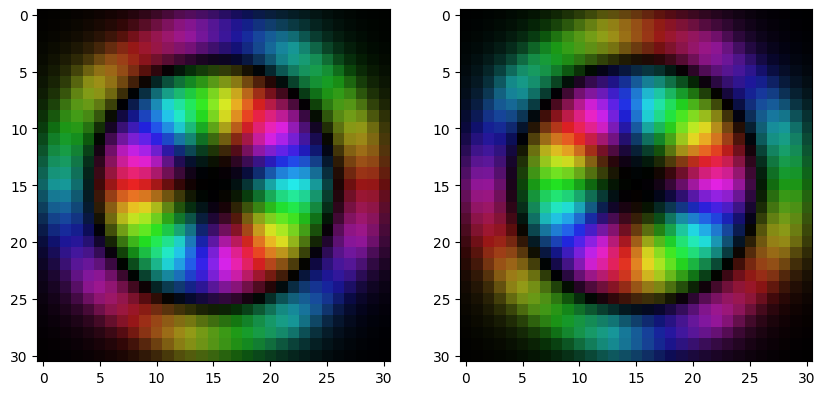

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(Complex2HSV(modes[10], 0, 0.065))
axs[1].imshow(Complex2HSV(output_field, 0, 0.065))

The mode has clearly gained some phase change due to the propagation in the wire and has kept its spatial values consistent while propagating. To check that this is the correct phase change, next try to use all the modes to rediscover the length of the MMF

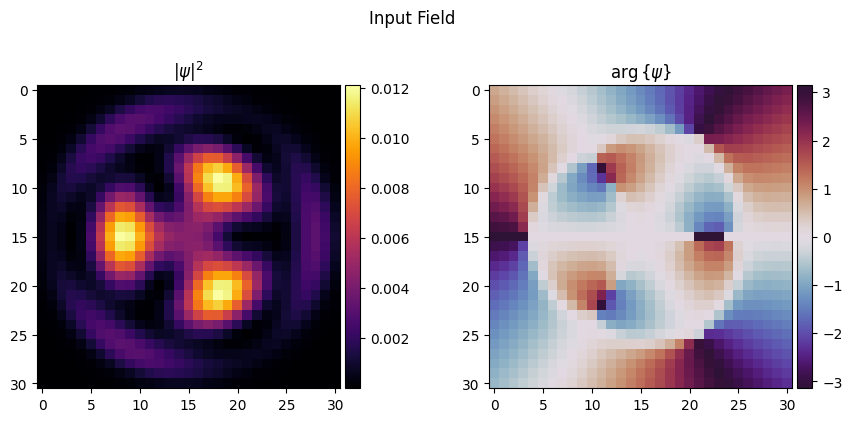

In [24]:
# Sum 2 PIMs together
field_1 = torch.from_numpy(modes[19])
field_2 = torch.from_numpy(modes[10])

input_field = Field(field_1 + field_2).to(device)

input_field.visualize(title="Input Field")

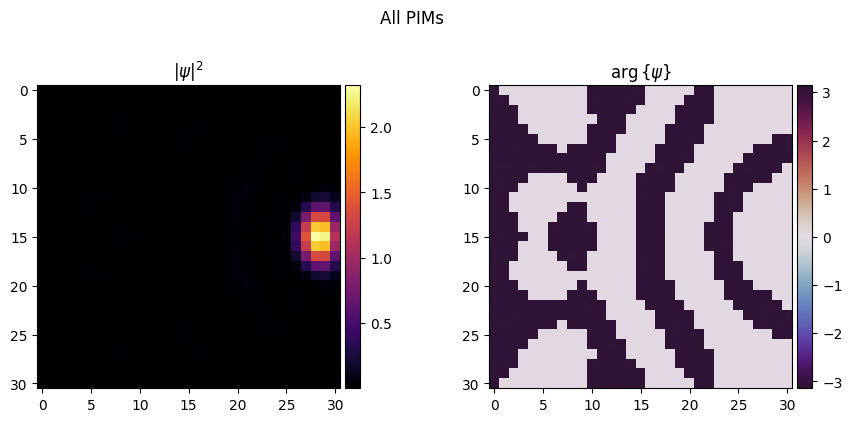

In [25]:
# Sum ALL the PIMs together
#input_field_all = torch.from_numpy(modes[0])
input_field_all = torch.from_numpy(np.zeros((31,31)))
for i in np.arange(0,42,1):
    input_field_all = input_field_all + torch.from_numpy(modes[i])

input_field = Field(input_field_all).to(device)
input_field.visualize(title="All PIMs")

input_field_np = np.zeros((31,31))
for i in np.arange(0,42,1):
    input_field_np = input_field_np + modes[i]


C:\Users\elija\AppData\Local\Temp\ipykernel_11372\841074018.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_arr[i,j] = np.exp(im*L*beta[i])


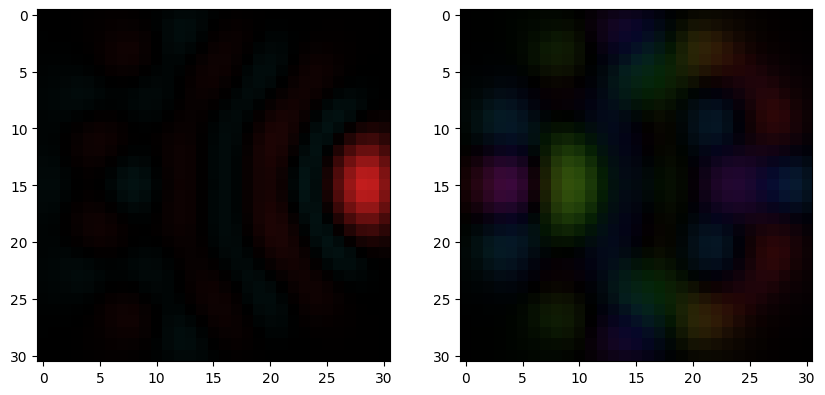

In [26]:
# Propagate this field by 1m to get an output field to use as the target field
output_field_vec = TM(beta=beta, mode_fields=modes, no_pims=42, pixel=961, L=1) @ vectorise(input_field_np)
output_field = rev_vector(output_field_vec,31)

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(Complex2HSV(input_field_np, 0, 2))
axs[1].imshow(Complex2HSV(output_field, 0, 2))

### Test for the length of the wire
For the first test, all modes are inputted and propagate for a length of 1m. Need to take the output field from that and use it as a target field for a NN to find the length of the MMF itself.

Perhaps create a function similar to TorchOptics's free space propagation function, but for propagation in an MMF, then summarise the TM using a phase modulator.

In [ ]:
# Make a function for the TM
def TM(beta, mode_fields, no_pims, pixel, L):
    """Forms a transmission matrix, TM, based on externally generated modes and their corresponding phase velocities.
    beta = phase velocities for modes (given as an ordered list array)
    mode_field = 2D electric field of the propagation invariant modes (PIMs), given as a 3D array
    no_pims = number of PIMs that can travel through the multimode optical fibre (MMF)
    pixel = total number of pixels the 2D electric field covers in real space
    L = Length of the MMF"""

    beta_arr = np.zeros((no_pims,no_pims)).astype(complex)
    im = np.sqrt(-1+0j)

    # Create the real space to PIM matrix
    pim = mode_fields[0].reshape(pixel,1)

    for i in np.arange(0,no_pims-1,1):
        pim = np.concatenate([pim, mode_fields[i+1].reshape(pixel,1)],axis=1)
    
    # Take the conjugate transpose of the pim matrix to be used in returning the field back to pixel coords
    pim_dag = np.transpose(np.conj(pim))

    # Make a diagonal PIM to PIM TM (each term is exp(i*L*beta), where L is the length of the MMF)
    for i in np.arange(0,no_pims,1):
        for j in np.arange(0,no_pims,1):
            if i==j:
                beta_arr[i,j] = np.exp(im*L*beta[i])
            else:
                pass
    
    # Combine each matrix to make the full TM for the MMF
    return pim @ beta_arr @ pim_dag


# Make a vectorising function
def vectorise(field):
    """Converts a 2D field and vectorises it into a column matrix.
    field = matrix representation of field"""
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def rev_vector(field, dim):
    """Converts a vectorised field back into a 2D square matrix representation.
    field = vectorised field
    dim = number of pixels on one side of the square matrix it will be turned into"""
    return field.reshape(dim,dim)

# Make a propagate function to help save time (and less complexity) in the future
def propagate(input_field, beta, modes, length, pytorch=True):
    """Takes an input field and the transmission matrix of a multimode optical fibre and finds the output after propagating for a given distance."""
    # Give option to use TorchOptics fields or not!
    output_field_vector = TM(beta=beta, mode_fields=modes, no_pims=42, pixel=961, L=length) @ vectorise(input_field)
    output_field = rev_vector(output_field_vector,31)
    if pytorch == 1:
        torch_field = torch.from_numpy(output_field).to(device) 
        return torch_field
    else: 
        return output_field

#### Use the function and an ANN to find the length of the MMF

In [67]:
# beta and modes were defined ealier in the notebook
input_field = input_field_np
target_field = propagate(input_field=input_field, beta=beta, modes=modes, length=1, pytorch=True)

C:\Users\elija\AppData\Local\Temp\ipykernel_11372\841074018.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_arr[i,j] = np.exp(im*L*beta[i])


In [71]:
torch.zeros(1,1)

tensor([[0.]])

In [72]:
system = propagate(input_field=input_field, beta=beta, modes=modes, length=Parameter(torch.zeros(1,1)), pytorch=True).to(device)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### PyTorch Dataset


In [ ]:
class fields_dataset(Dataset):
    def __init__(self, data_dir):
        #super().__init__()
        pass
    
    def __len__(self):
        """DataLoader needs to know how many examples are in the dataset to train off of."""
        pass
    def __getitem__(self, index):
        """Returns the indexed item in the dataset."""
        pass

In [ ]:
# Make a class to use for the model
class length_model(nn.Module):
    """ANN model for finding the length of an MMF given an input and ouput field.
    Length is the only tuneable parameter in this case."""
    def __init__(self):
        #super(length_model, self).__init__()
        self.hidden = nn.Linear(961, 9)
        self.output = nn.Linear(9, 961)

    def forward(self, x):
        return propagate(input_field=input_field, beta=beta, modes=modes, length=self.x, torch=False)

model = length_model()
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)
losses = [] # Create a list to graph later

for iteration in range(1,401):
    optimiser.zero_grad() # Type of optimisation
    output_field = model(x)

    # Calculate losses
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
# Make a class to use for the model
class length_model(nn.Module):
    """ANN model for finding the length of an MMF given an input and ouput field.
    Length is the only tuneable parameter in this case."""
    def __init__(self):
        super(length_model, self).__init__()
        self.w = Parameter(torch.tensor(0.0, dtype=torch.float32, requires_grad=True))

    def forward(self, input):
        return propagate(input_field=input_field, beta=beta, modes=modes, length=self.w, torch=False)